In [1]:
import h5py
import numpy as np

# Load the HDF5 dataset
filename = 'reaction_diffusion_training.h5'
with h5py.File(filename, 'r') as h5file:
    d1_values = h5file['d1'][:]
    beta_values = h5file['beta'][:]
    t_values = h5file['t'][:]
    x_values = h5file['x'][:]
    y_values = h5file['y'][:]
    u_data = h5file['u'][:]  # Shape: (num_samples, len(t), n, n)
    v_data = h5file['v'][:]  # Shape: (num_samples, len(t), n, n)

print(f"Loaded dataset with {u_data.shape[0]} samples.")

Loaded dataset with 50 samples.


In [2]:
# Reshape data into 2D matrix (num_samples * time_steps, grid_points)
num_samples, time_steps, n, _ = u_data.shape
grid_points = n * n
u_snapshots = u_data[:num_samples,:].reshape(num_samples * time_steps, grid_points).T
# v_snapshots = v_data[:num_samples,:].reshape(num_samples * time_steps, grid_points).T

# Combine u and v data (optional: POD on combined fields)
# combined_snapshots = np.vstack([u_snapshots, v_snapshots])  # Shape: (2 * grid_points, num_snapshots)

In [3]:
from sklearn.utils.extmath import randomized_svd

# Randomized SVD
n_components = 100  # Number of dominant modes to compute
U, Sigma, VT = randomized_svd(u_snapshots[:,::3], n_components=n_components, random_state=42)

print(f"Computed {U.shape[1]} approximate POD modes using randomized SVD.")

# Extract POD modes and singular values
POD_modes = U  # Each column is a POD mode
singular_values = Sigma  # Singular values
time_coefficients = VT.T  # Time-dependent coefficients

print(f"Computed {POD_modes.shape[1]} POD modes.")

Computed 100 approximate POD modes using randomized SVD.
Computed 100 POD modes.


In [4]:
# Load the HDF5 dataset
filename = 'reaction_diffusion_testing.h5'

with h5py.File(filename, 'r') as h5file:
    d1_values_test   = h5file['d1'][:]
    beta_values_test = h5file['beta'][:]
    t_values_test    = h5file['t'][:]
    x_values_test    = h5file['x'][:]
    y_values_test    = h5file['y'][:]
    u_data_test      = h5file['u'][:]  # Shape: (num_samples, len(t), n, n)
    v_data_test      = h5file['v'][:]  # Shape: (num_samples, len(t), n, n)

print(f"Loaded dataset with {u_data_test.shape[0]} samples.")



Loaded dataset with 50 samples.


In [5]:
print(u_data[1,:])
print(u_data_test[1,:])

[[[-0.70358468 -0.78230255 -0.84975396 ... -0.46787323 -0.55388342
   -0.63514037]
  [-0.77239673 -0.84222677 -0.89985792 ... -0.3581957  -0.4505241
   -0.53912342]
  [-0.83259423 -0.89276427 -0.93991157 ... -0.24402939 -0.34141797
   -0.43618312]
  ...
  [ 0.42493679  0.32789959  0.22822959 ...  0.9918887   0.96976784
    0.93364653]
  [ 0.52717948  0.43618312  0.34141797 ...  0.97360734  0.93991157
    0.89276427]
  [ 0.62289864  0.53912342  0.4505241  ...  0.94471258  0.89985792
    0.84222677]]

 [[-0.46965829 -0.53663518 -0.61065879 ... -0.24637192 -0.32653467
   -0.3994592 ]
  [-0.74454022 -0.82122981 -0.88342543 ... -0.42251159 -0.51161459
   -0.60966372]
  [-0.76002925 -0.85961188 -0.90923945 ... -0.28959452 -0.3816942
   -0.51400516]
  ...
  [ 0.52425454  0.36800446  0.27535654 ...  0.97134787  0.9481942
    0.84396532]
  [ 0.62085002  0.49477529  0.40558004 ...  0.96870342  0.93234098
    0.84575537]
  [ 0.43177313  0.33640526  0.2519987  ...  0.69278289  0.63957301
    0.566

In [6]:
print(U.shape)

(16384, 100)


In [7]:
print(u_snapshots.shape)

(16384, 80050)


In [15]:
# Reshape training data into a 2D matrix (num_samples * time_steps, grid_points)
num_samples_train, time_steps_train, n_train, _ = u_data.shape
grid_points_train = n_train * n_train

# Subsample training data
num_samples_to_use = 5

end_index = (num_samples_to_use * (time_steps_train))

snapshots_train = u_data[:num_samples_to_use,:].reshape(end_index, grid_points_train).T

# Compute time coefficients for training data
time_coefficients_train = U.T @ snapshots_train[:, :end_index]

# Reconstruct training snapshots
snapshots_reconstructed_train = U @ time_coefficients_train

# Calculate reconstruction error for training data
reconstruction_error_train = (
    np.linalg.norm(snapshots_train[:, :end_index] - snapshots_reconstructed_train)
    / np.linalg.norm(snapshots_train[:, :end_index])
)

print(f"Train Reconstruction Error: {reconstruction_error_train:.12f}")

# Reshape testing data into a 2D matrix (num_samples * time_steps, grid_points)
num_samples_test, time_steps_test, n_test, _ = u_data_test.shape
grid_points_test = n_test * n_test

# Subsample testing data
snapshots_test = u_data_test[:num_samples_to_use,:].reshape(end_index, grid_points_test).T

# Compute time coefficients for testing data
time_coefficients_test = U.T @ snapshots_test[:, :end_index]

# Reconstruct testing snapshots
snapshots_reconstructed_test = U @ time_coefficients_test

# Calculate reconstruction error for testing data
reconstruction_error_test = (
    np.linalg.norm(snapshots_test[:, :end_index] - snapshots_reconstructed_test)
    / np.linalg.norm(snapshots_test[:, :end_index])
)

print(f"Test Reconstruction Error: {reconstruction_error_test:.12f}")

Train Reconstruction Error: 0.020759238081
Test Reconstruction Error: 0.011058791948


In [16]:
print(Sigma)

[8867.17679066 8804.25553206 3180.15743753 3169.63096744 2042.01553334
 2008.43004295 1646.69748217 1624.02775598 1453.00428295 1436.96333897
 1066.15663823 1062.63751278  765.58466022  755.85851085  623.76356699
  619.92773754  529.84152774  513.22601698  479.56964212  466.23277131
  453.39296899  438.79189715  395.67325154  388.87073572  356.24555924
  347.02768871  309.68254468  295.31780805  286.12631607  281.69207688
  273.97852585  267.9543999   249.05191311  247.17987926  228.61793532
  227.83437893  217.07620788  214.41936852  201.07414976  197.74896481
  194.86728004  193.5738554   181.37968363  180.83926599  172.646664
  170.65204821  162.93863725  159.90615324  153.76670019  150.36995739
  146.04762919  143.83214518  139.76705672  136.70220861  134.12763682
  132.75991519  126.76235714  125.89761321  124.4870068   123.08289871
  114.1191178   113.38855254  111.55715504  108.83940929  107.34688391
  106.1521734   103.68829995  100.49700854   98.14663383   94.94843918
   94.61

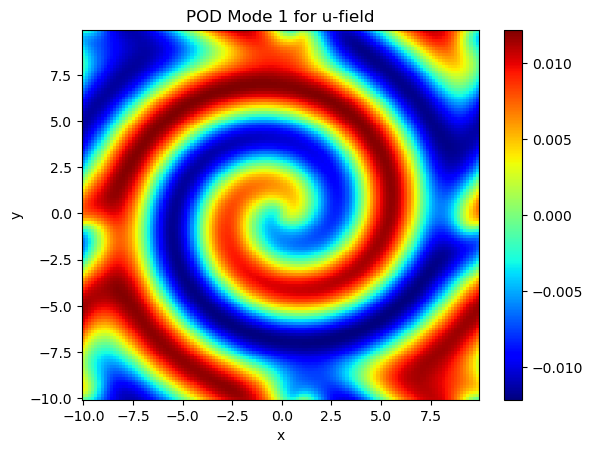

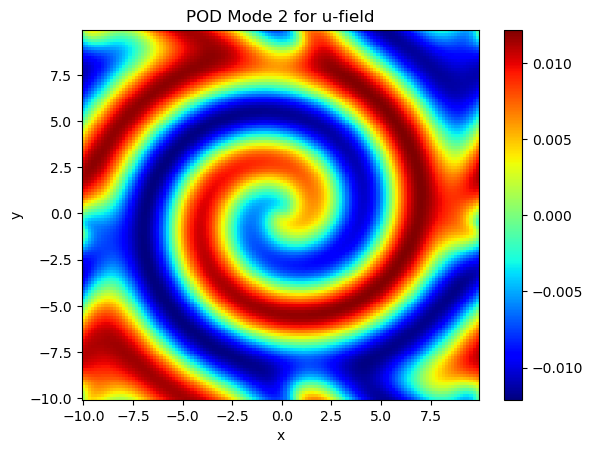

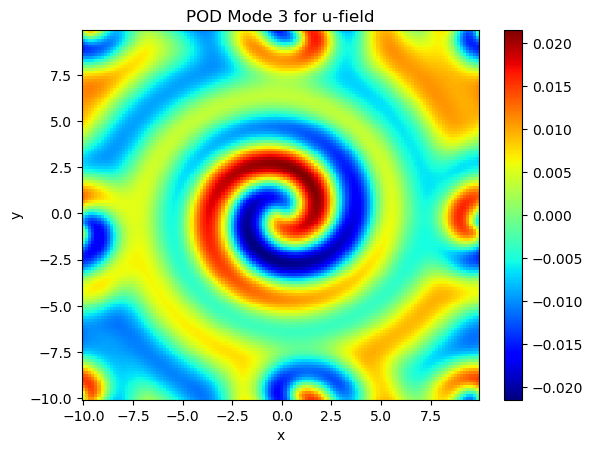

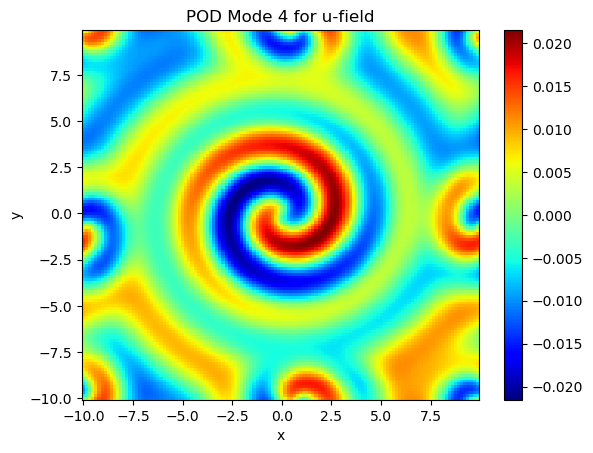

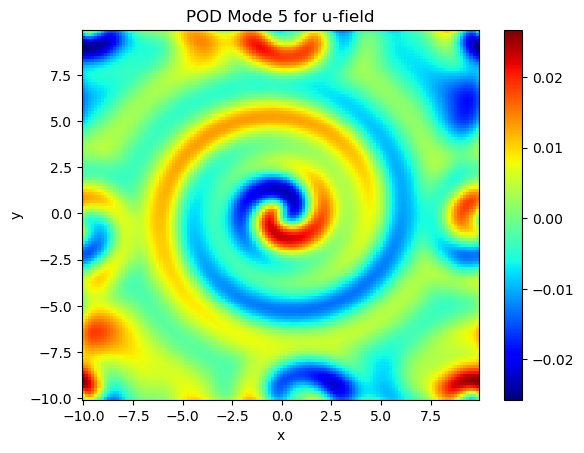

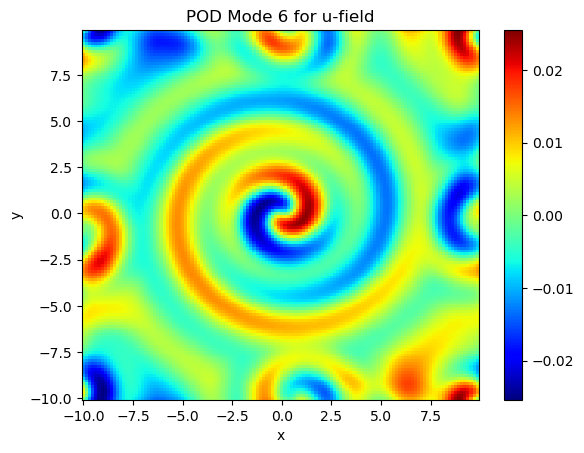

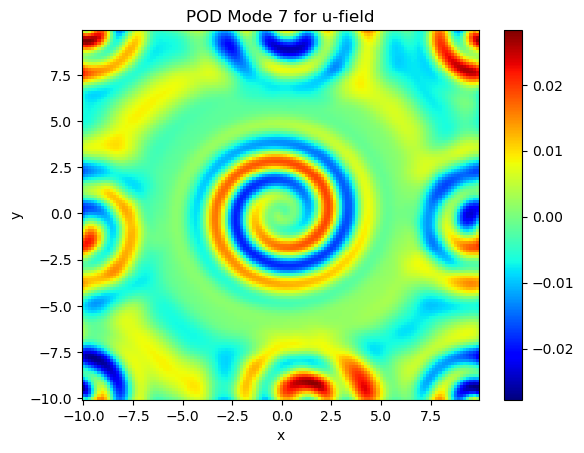

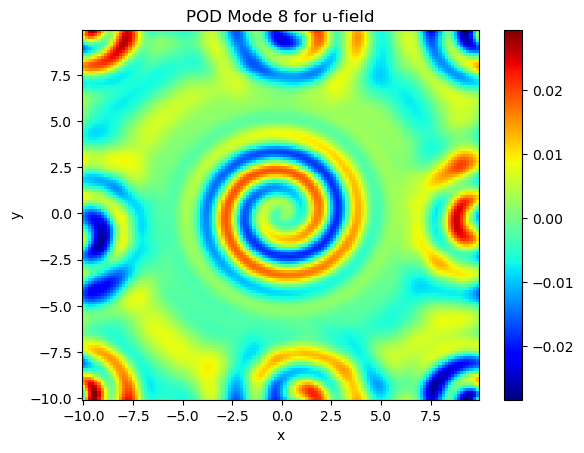

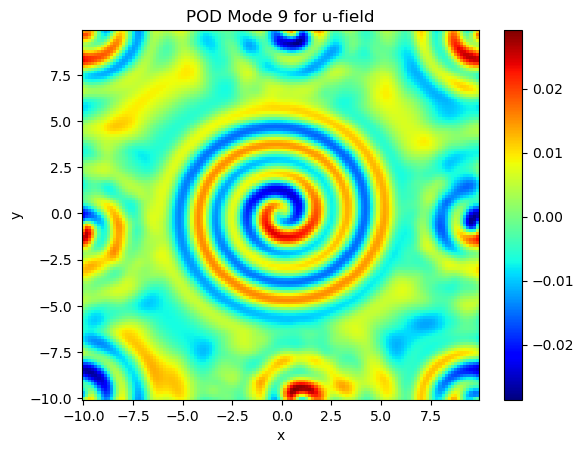

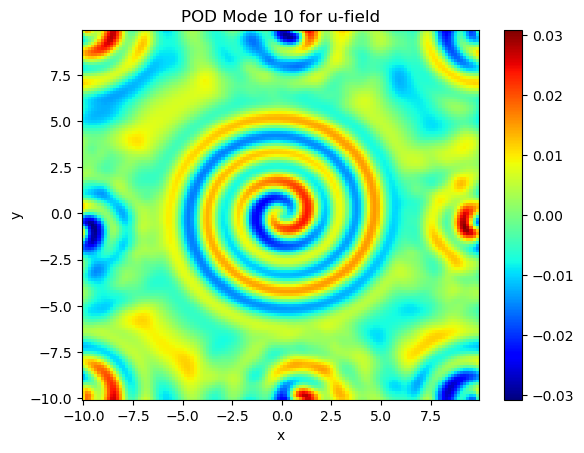

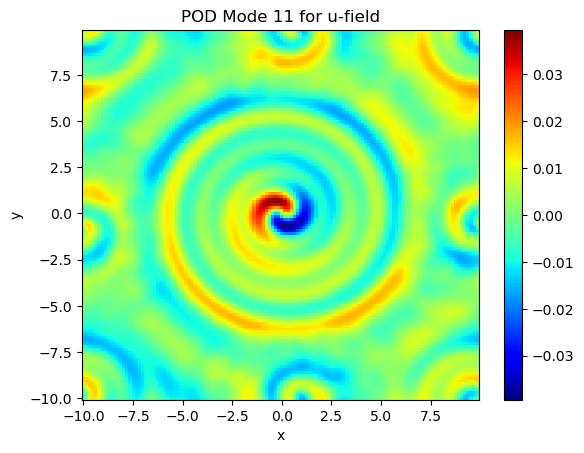

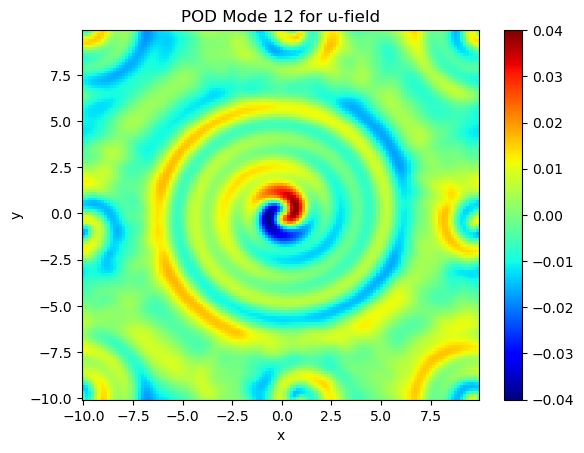

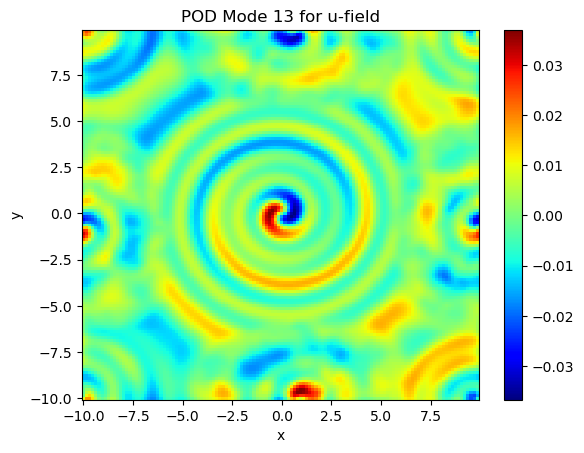

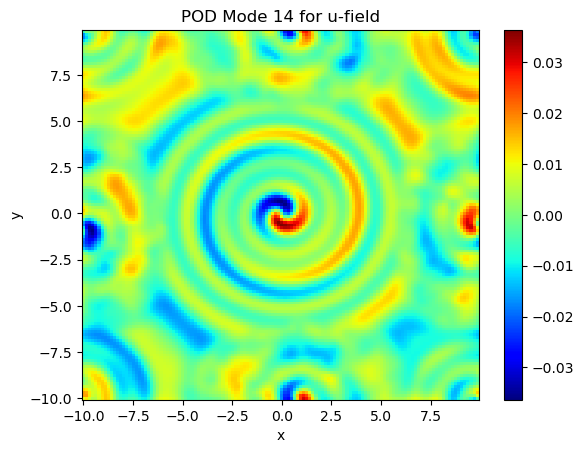

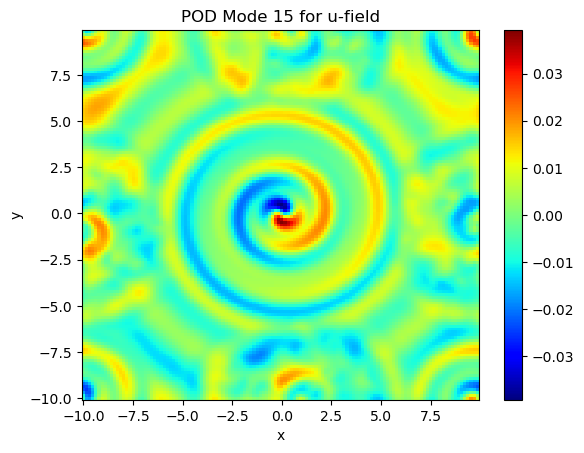

In [18]:
import matplotlib.pyplot as plt

# Reshape and visualize the first few POD modes for the u-field
num_modes_to_plot = 15
for i in range(num_modes_to_plot):
    mode = U[:grid_points, i].reshape((n, n))  # Extract mode for u-field
    plt.figure()
    plt.pcolormesh(x_values, y_values, mode, shading='auto', cmap='jet')
    plt.colorbar()
    plt.title(f"POD Mode {i+1} for u-field")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

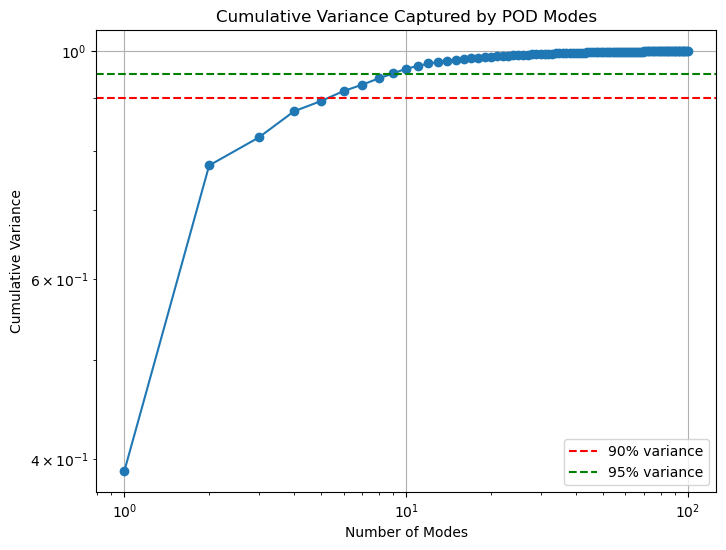

Number of modes to capture 90% variance: 6
Number of modes to capture 95% variance: 9
Number of modes to capture 99% variance: 24
Number of modes to capture 99.9% variance: 66


In [21]:
# Assuming 'Sigma' contains the singular values from SVD

# Compute the variance captured by each mode
variance_captured = Sigma**2 / np.sum(Sigma**2)

# Compute the cumulative variance
cumulative_variance = np.cumsum(variance_captured)

# Plot cumulative variance
plt.figure(figsize=(8, 6))
plt.loglog(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.axhline(0.9, color='r', linestyle='--', label='90% variance')
plt.axhline(0.95, color='g', linestyle='--', label='95% variance')
plt.title('Cumulative Variance Captured by POD Modes')
plt.xlabel('Number of Modes')
plt.ylabel('Cumulative Variance')
plt.grid(True)
plt.legend()
plt.show()

# Optionally print the number of modes needed for 90% and 95% variance
n_modes_90 = np.searchsorted(cumulative_variance, 0.9) + 1
n_modes_95 = np.searchsorted(cumulative_variance, 0.95) + 1
n_modes_99 = np.searchsorted(cumulative_variance, 0.99) + 1
n_modes_999 = np.searchsorted(cumulative_variance, 0.999) + 1
print(f"Number of modes to capture 90% variance: {n_modes_90}")
print(f"Number of modes to capture 95% variance: {n_modes_95}")
print(f"Number of modes to capture 99% variance: {n_modes_99}")
print(f"Number of modes to capture 99.9% variance: {n_modes_999}")

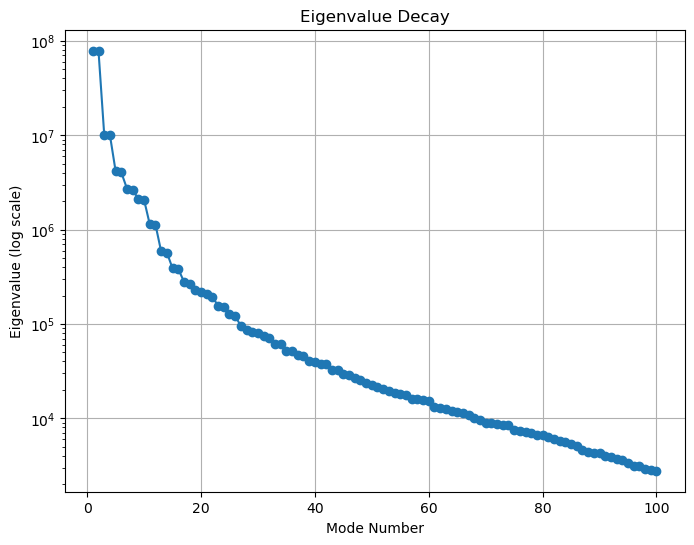

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'Sigma' contains the singular values from SVD

# Compute the eigenvalues (square of singular values)
eigenvalues = Sigma**2

# Plot eigenvalue decay
plt.figure(figsize=(8, 6))
plt.semilogy(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='-')
plt.title('Eigenvalue Decay')
plt.xlabel('Mode Number')
plt.ylabel('Eigenvalue (log scale)')
plt.grid(True)
plt.show()

In [24]:
import pandas as pd

# Assume:
# - 'd1_values' and 'beta_values' are arrays of parameters.
# - 't_values' is the array of time steps.
# - 'time_coefficients' is from SVD (shape: snapshots x modes).
# - 'num_samples', 'time_steps' are defined.



# Reshape d1 and beta to align with snapshots
d1_repeated = np.repeat(d1_values[:num_samples], time_steps)  # Repeat for all time steps
beta_repeated = np.repeat(beta_values[:num_samples], time_steps)  # Repeat for all time steps

# Tile the time array to align with snapshots
time_repeated = np.tile(t_values, num_samples)  # Tile for all samples

# Combine all inputs
inputs = np.vstack([d1_repeated, beta_repeated, time_repeated]).T  # Shape: (snapshots, 3)

# Combine inputs with coefficients (targets)
dataset = np.hstack([inputs])  # Shape: (snapshots, 3 + num_modes)

# Convert to DataFrame for easy manipulation
columns = ['d1', 'beta', 'time']
df = pd.DataFrame(dataset, columns=columns)

# Export to CSV
df.to_csv('pod_coefficients_dataset_usnapshots.csv', index=False)
print("Dataset exported to 'pod_coefficients_dataset.csv'.")

# Alternatively, save as HDF5


Dataset exported to 'pod_coefficients_dataset.csv'.
Dataset exported to 'pod_coefficients_dataset.h5'.


In [26]:
num_samples

50

In [27]:
d1_repeated = np.repeat(d1_values_test[:num_samples], time_steps)  # Repeat for all time steps
beta_repeated = np.repeat(beta_values_test[:num_samples], time_steps)  # Repeat for all time steps

# Tile the time array to align with snapshots
time_repeated = np.tile(t_values, num_samples)  # Tile for all samples

# Combine all inputs
inputs = np.vstack([d1_repeated, beta_repeated, time_repeated]).T  # Shape: (snapshots, 3)

# Combine inputs with coefficients (targets)
dataset = np.hstack([inputs])  # Shape: (snapshots, 3 + num_modes)

# Convert to DataFrame for easy manipulation
columns = ['d1', 'beta', 'time']
df = pd.DataFrame(dataset, columns=columns)

# Export to CSV
df.to_csv('pod_coefficients_testing_dataset_usnapshots.csv', index=False)
print("Dataset exported to 'pod_coefficients_dataset.csv'.")

with h5py.File('pod_coefficients_testing_dataset.h5', 'w') as h5file:
    h5file.create_dataset('inputs', data=inputs)  # Parameters + time
    h5file.create_dataset('coefficients', data=time_coefficients)  # POD coefficients
print("Dataset exported to 'pod_coefficients_dataset.h5'.")

Dataset exported to 'pod_coefficients_dataset.csv'.
Dataset exported to 'pod_coefficients_dataset.h5'.


: 

In [25]:
# Export the basis to an HDF5 file
with h5py.File('pod_basis.h5', 'w') as h5file:
    # Save POD modes (spatial basis)
    h5file.create_dataset('POD_modes', data=POD_modes)  # Shape: (grid_points, num_modes)
    
    # Save singular values
    h5file.create_dataset('singular_values', data=Sigma)  # Shape: (num_modes,)
    
    # Save spatial grid
    h5file.create_dataset('x', data=x_values)  # Shape: (n,)
    h5file.create_dataset('y', data=y_values)  # Shape: (n,)
    
    # Save metadata
    h5file.attrs['grid_size'] = len(x_values)  # Number of grid points along one dimension
    h5file.attrs['num_modes'] = POD_modes.shape[1]  # Number of modes saved

print("POD basis exported to 'pod_basis.h5'.")

POD basis exported to 'pod_basis.h5'.
